In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gseapy as gp
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# set working directory
work_dir = '/home/project/organoids'
repo_dir = f'{work_dir}/project_labubu'
data_dir = f'{work_dir}/transfered_from_galaxy'
results_path = f'{repo_dir}/results/dge_gsea'
# create results directory if does not exist
os.makedirs(results_path,exist_ok=True)

In [3]:
# fill dataset metadata
# add dataset number and name
dat_met = {'ERP142256':{'name':'CRC tumoroid'},
          'ERP111852':{'name':'Lung bud tip'}}
# add paths to samples list and deseq2 results
samples_file = f'{repo_dir}/data/?/SRR_Acc_List.txt'
samples_organoid_file = f'{repo_dir}/data/?/SRR_Acc_List-organoid.txt'
deseq2_file = f'{data_dir}/?/deseq2/deseq2_result'
dge_gsea_dir = f'{results_path}/?'
for dataset in dat_met:
    dat_met[dataset]['samples_file']=samples_file.replace('?',dataset)
    dat_met[dataset]['samples_organoid_file']=samples_organoid_file.replace('?',dataset)
    dat_met[dataset]['deseq2_file']=deseq2_file.replace('?',dataset)
    dat_met[dataset]['dge_gsea_dir']=dge_gsea_dir.replace('?',dataset)
    # create datasets subfolders in results directory if do not exist
    os.makedirs(f'{results_path}/{dataset}',exist_ok=True)

In [4]:
# import statistical test results: organoid -vs- tissue
colnames = ['GeneID',	'Base mean',	'log2(FC)',	'StdErr',	'Wald-Stats',	'P-value',	'P-adj']
# stuck results in one table
deseq2_data = []
for dataset in dat_met:
    results_path = dat_met[dataset]['deseq2_file']
    df = pd.read_csv(results_path, sep='\t', names = colnames)
    df['dataset'] = dataset
    deseq2_data.append(df)
deseq2_data = pd.concat(deseq2_data, ignore_index=True)

In [5]:
# create function that visualises deseq2 results in volcano plot
def dge_volcano_plot(data, save_dir, title=None, fc_thresh = 2, pval_thresh = 0.01):
    """
    Input:
        data - deseq2 result for one dataset
        save_dir - directory where save the plot
        title - plot name (optional)
        fc_thresh - Log2(Fold Change) threshold (default 2)
        pval_thresh - p-value threshold (default 0.01)
    """
    # Set significance threshold
    sig_thresh = -np.log10(pval_thresh)
    # Define colors
    data['color'] = 'grey'
    data.loc[(data['log2(FC)'] > fc_thresh) & (data['P-adj'] < pval_thresh), 'color'] = 'red'
    data.loc[(data['log2(FC)'] < -fc_thresh) & (data['P-adj'] < pval_thresh), 'color'] = 'blue'
    # Transform p-value
    data['-log10(P-adj)'] = -np.log(data['P-adj'])
    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(data['log2(FC)'], data['-log10(P-adj)'], c=data['color'], alpha=0.7)
    # Threshold lines
    plt.axvline(fc_thresh, color='black', linestyle='--')
    plt.axvline(-fc_thresh, color='black', linestyle='--')
    plt.axhline(sig_thresh, color='black', linestyle='--')
    # Axis annotation
    if title: plt.title(title)
    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10 p-value adjusted')
    plt.savefig(f"{save_dir}/volcanoplot.svg", format="svg", bbox_inches ='tight' )
    plt.show()

/home/project/organoids/conda_envs/organoids/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


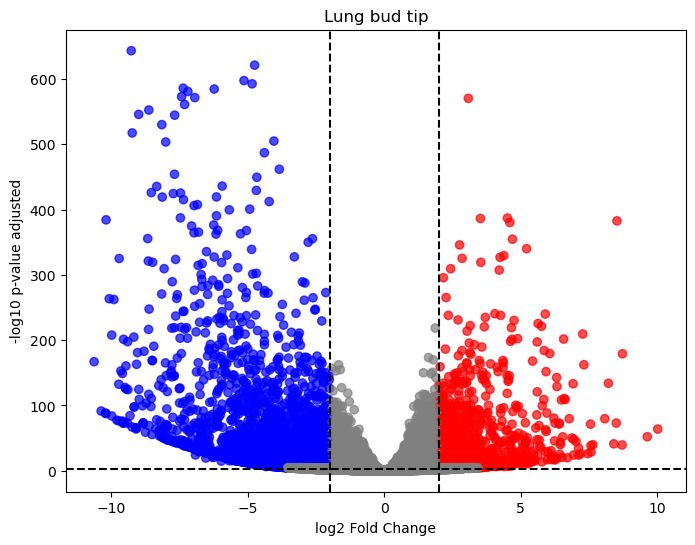

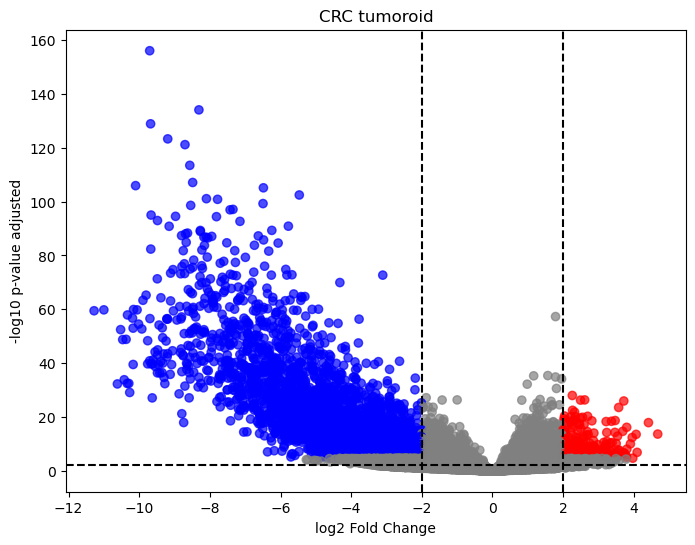

In [6]:
# do volcano plot for each dataset
for dataset, data in deseq2_data.groupby('dataset'):
    save_dir = dat_met[dataset]['dge_gsea_dir']
    title = f"{dat_met[dataset]['name']}"
    dge_volcano_plot(data, save_dir, title)

In [7]:
# create function to do GSEA analysis
def gsea_dotplot(data, save_dir, title=None, export=True, gene_sets='KEGG_2021_Human', organism='Human', fdr = 0.25):
    """
    Input:
        data - deseq2 result for one dataset
        save_dir - directory where save the plot
        title - plot name (optional)
        export - return GSEA result
        gene_sets - catalog of gene sets (default KEGG_2021_Human)
        organism - (defult Human)
        fdr - corrected p-value threshold (default 0.25)
    """
    # rank genes
    rnk = data.sort_values('log2(FC)', ascending=False)[["GeneID", 'log2(FC)']]
    # GSEA
    gsea_results = gp.prerank(
        rnk=rnk,
        gene_sets=gene_sets,
        organism=organism,
        permutation_num=1000,
        seed=42,
        verbose=True
    )
    # convert into table
    res = gsea_results.res2d
    # save
    res.to_csv(f'{save_dir}/{gene_sets}_res.tsv',sep='\t')
    # plot gene sets
    ax = gp.dotplot(res,
                   column="FDR q-val",
                    cmap=plt.cm.viridis,
                     size=6, # adjust dot size
                     figsize=(4,5), cutoff = fdr, show_ring=False)
    ax.set_xlabel('normalized enrichment score')
    if title: ax.set_title(title)
    plt.savefig(f"{save_dir}/{gene_sets}_dotplot.svg", format="svg", bbox_inches ='tight' )
    plt.show()
    plt.close()
    if export: return gsea_results

2026-01-10 17:54:07,705 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2026-01-10 17:54:07,904 [WARNING] Duplicated values found in preranked stats: 20.33% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-01-10 17:54:07,905 [INFO] Parsing data files for GSEA.............................
2026-01-10 17:54:08,204 [INFO] Downloading and generating Enrichr library gene sets......
2026-01-10 17:54:12,713 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-10 17:54:12,715 [INFO] 0178 gene_sets used for further statistical testing.....
2026-01-10 17:54:12,715 [INFO] Start to run GSEA...Might take a while..................
2026-01-10 17:54:24,856 [INFO] Congratulations. GSEApy runs successfully................



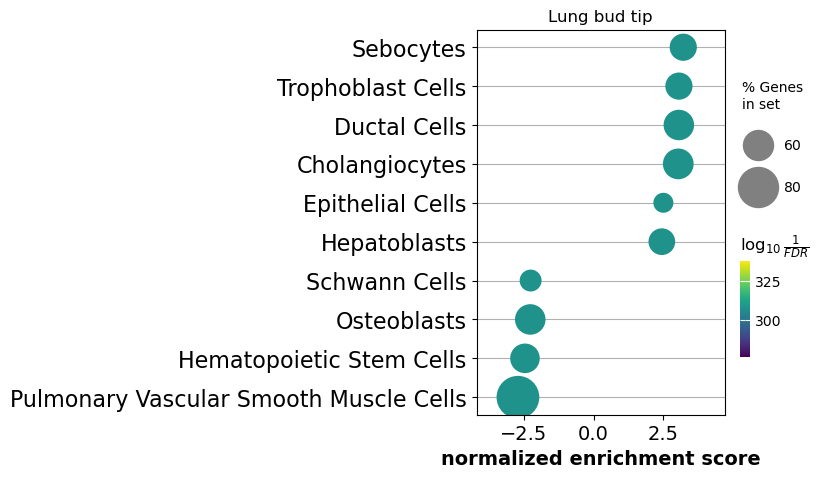

2026-01-10 17:54:25,332 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2026-01-10 17:54:25,410 [WARNING] Duplicated values found in preranked stats: 7.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-01-10 17:54:25,412 [INFO] Parsing data files for GSEA.............................
2026-01-10 17:54:25,459 [INFO] Enrichr library gene sets already downloaded in: /home/valeriia/.cache/gseapy, use local file
2026-01-10 17:54:25,477 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-10 17:54:25,479 [INFO] 0178 gene_sets used for further statistical testing.....
2026-01-10 17:54:25,479 [INFO] Start to run GSEA...Might take a while..................
2026-01-10 17:54:41,963 [INFO] Congratulations. GSEApy runs successfully................



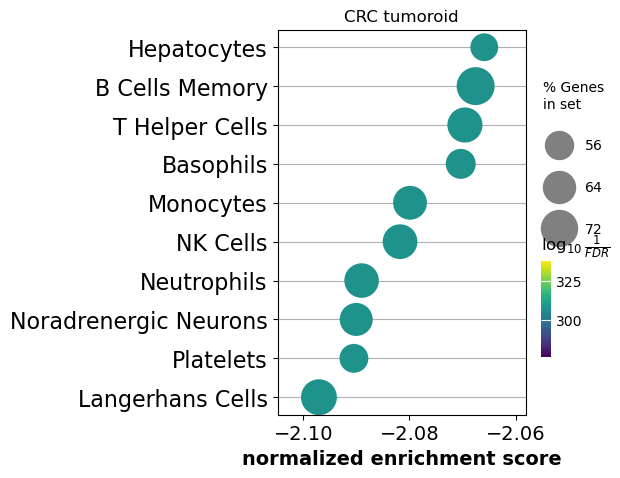

In [10]:
# do GSEA and dot plot for each dataset
for dataset, data in deseq2_data.groupby('dataset'):
    save_dir = dat_met[dataset]['dge_gsea_dir']
    title = f"{dat_met[dataset]['name']}"
    # Pathways
    gsea_dotplot(data, save_dir, title, export=False)
    # Cell type
    gsea_dotplot(data, save_dir, title, export=False, gene_sets='PanglaoDB_Augmented_2021')

In [9]:
# GSEA plot
#res = gsea_kegg.res2d.copy()
#res_sig = res[res["FDR q-val"] < 0.25]
#top_up = (
#    res_sig[res_sig["NES"] > 0]
#    .sort_values("NES", ascending=False)
#    .head(5)
#)
#top_down = (
#    res_sig[res_sig["NES"] < 0]
#    .sort_values("NES", ascending=True)
#    .head(5)
#)
#terms = list(top_down.Term) + list(top_up.Term)
#axs = gsea_kegg.plot(
#    terms=terms,
#    show_ranking=True,
#    figsize=(3, 4)
#)
